# ResNetClassifier: Medical Image Classification Based on ResNet50V2

This notebook describes **RestNetClassifier**, a convolutional neural network (CNN)-based classification model designed to detect whether a medical image contains any of the organs of interest, namely the stomach, small intestine, or large intestine. If the slice includes at least one of these organs, the classification yields a True label; otherwise, it returns a False label.

The classification model is an integral component of the overall segmentation pipeline shown in the figure below, with the objective of filtering only the slices containing segments to pass through to the SegFormer segmentation model.

<br>
<div align="center">
<img src="../images/model_workflow.png" width="550" class="center">
</div>
<br>

The notebook includes the implementation of the model and the training/validation process to get the model coefficients. The technical information abut this model is given next:

* **Frameworks:** Keras, Tensorflow
* **Convolutional layers**: ResNet50V2 (learning transfer)
* **Fully connected (dense) layer**: 1x 256 neurons with relu functions + 1x dropout layer
* **Output layer**: 1 neuron with sigmoid function

# Authors
Tina Mangum, Ali Rahjouei, Sergio Sanz, Di Walsh

# Import Libraries

In [1]:
#!pip install tensorflow
import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50, ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve, roc_auc_score
from livelossplot import PlotLossesKeras
from keras.models import load_model, Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

# Constants and Hyperparameters

We define in a unified place the constants and hyperparameters needed to train the model.

In [2]:
BATCH_SIZE = 64
EPOCHS = 30
LEARN_RATE = 0.001
NEURONS = 256

MEAN = 0.136
STD = 0.178

IM_SIZE = 288
DATASET = 'classification_data' # Add here the path of the image dataset

TARGET_RECALL = 0.995

# Evaluation Functions

This section comprises three functions:
* **Custom Normalization**: Normalizes the input images using a custom mean and standard deviation. These statitical values have been obtined from the training dataset.
* **Plot Learning**: Plots the learning curves of the classification model during training.
* **Find ROC Threshold True Positive Rate**: Calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
* **Plot Confusion Matrix**: Prints and plots the confusion matrix.
* **Plot Class Distribution**: Plots the statistical distrution of the two predicted classes.

In [3]:
# Function for custom normalization
def custom_normalization(image):
    image = image / 255.0
    image = (image - MEAN) / STD
    return image

# ploting model loss during training, created by Daniel: https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
class plot_learning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()


def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    fpr, tpr, thr = roc_curve(y, y_pred)

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

def plot_class_distribution(y, y_pred):
    """
    This function plots the statistical distrution of the two predicted classes.
    """
    df = pd.DataFrame({'Predicted': list(y_pred), 'Real': list(y)})
    df.Predicted = df.Predicted.astype(float)
    df.Real = df.Real.astype(int)
    sns.kdeplot(data=df, x='Predicted', hue='Real', fill=True, alpha=0.2, linewidth=1.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Values for Each Class')
    plt.legend(labels=['Organs: YES', 'Organs: NO'])
   # plt.show()

# Binary Classification Model

This section includes the implementation of the ResNetClassifier based on the ResNet50V2 model and makes predictions on the training dataset. The trained model is then stored in a .keras file.

In [4]:
# Preprocess the images and create data generators with augmentation and normalization
train_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],  # Adjust brightness randomly between 0.5 and 1.5
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization)

train_generator = train_datagen.flow_from_directory(
    DATASET + '/train',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    DATASET + '/train',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    DATASET + '/test',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Load the pre-trained ResNet50V2 model
#wgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
resnet_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

# Freeze the layers in the base model
for layer in resnet_base.layers:
    layer.trainable = False

# Get the output tensor of the base ResNet50V2 model
resnet_output = resnet_base.output

# Flatten the output tensor
flattened_output = Flatten()(resnet_output)

# Add the fully connected layers: 1 layer with 256 neurons and the output layer with a sigmoid function
deep_layer = Dense(NEURONS, kernel_initializer=glorot_uniform(seed=42), activation='relu')(flattened_output)
dropout = Dropout(0.5)(deep_layer)
output = Dense(1, activation='sigmoid')(dropout)

# Create the model
model = Model(inputs=resnet_base.input, outputs=output)

# Compile de model
optimizer = Adam(learning_rate=LEARN_RATE)
eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)

Found 25550 images belonging to 2 classes.
Found 6386 images belonging to 2 classes.
Found 6560 images belonging to 2 classes.


# Training and Validation

This section performs the training and validation processes of the model.

In [5]:
# Train the model
#history = model.fit(
#    train_generator,
#    batch_size=BATCH_SIZE,    
#    epochs=EPOCHS,
#    verbose=1,
#    validation_data=validation_generator,    
#    #class_weight=class_weight,
#    callbacks=plot_learning()
#)

In [6]:
# Save model
#model.save("models/resnet50v2_nn256_lr0001_relu_batch64_epoch50_v4.keras")

In [7]:
# Print the model summary
#model.summary()

In [ ]:
# To continue training from the last checkpoint
#model = load_model("models/resnet50v2_nn256_lr0001_relu_batch64_epoch50_v4.keras", compile=False)
#optimizer = Adam(learning_rate=LEARN_RATE)
#eval_metrics = [tf.keras.metrics.Precision(thresholds=0.5), tf.keras.metrics.Recall(thresholds=0.5), "accuracy"]
#model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=eval_metrics)
#history = model.fit(
#    train_generator,
#    batch_size=BATCH_SIZE,    
#    epochs=30,
#    verbose=1,
#    validation_data=validation_generator,    
#    callbacks=plot_learning()
#)

# Testing and Evaluation

In this section, the classification model is evaluated using various performance metrics, including the ROC curve, ROC AUC score, and confusion matrix. Additionally, the threshold that achieves a target recall of TARGET_RECALL (99.5% by default) is computed. This threshold will be utilized in the web application to determine whether the slice contains organs of interest or not.

In [8]:
model = load_model('models/resnet50v2_nn256_lr0001_relu_batch64_epoch30_v4.keras')

In [9]:
y_pred = model.predict(test_generator).reshape(-1)
y_test = test_generator.labels

C:\Users\ssre_\.venv_common\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step


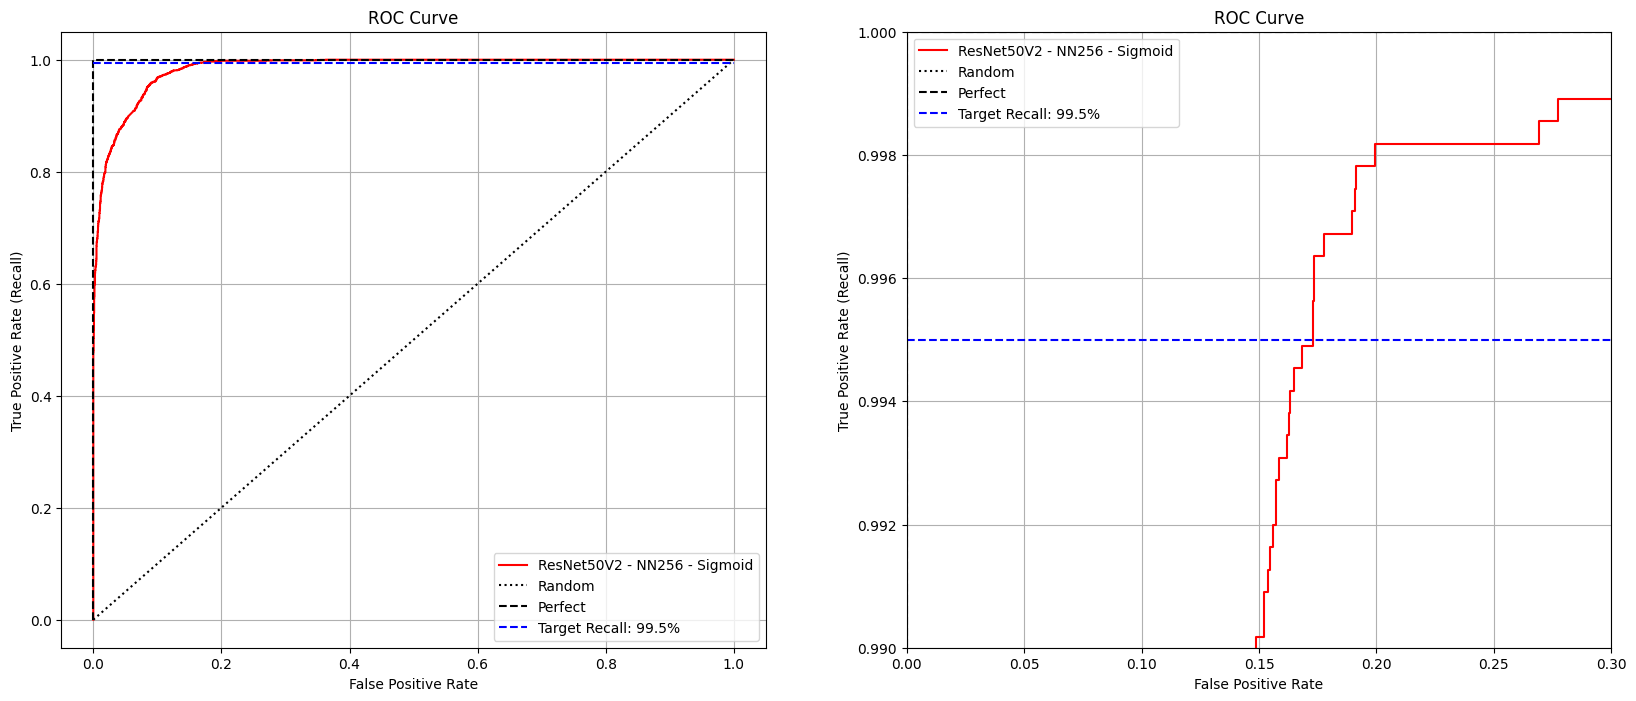

In [10]:
fpr, tpr, thr_roc = roc_curve(y_test, y_pred)
recall_label=f"Target Recall: {100*TARGET_RECALL}%"

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
plt.plot(fpr, tpr, 'r-', label = 'ResNet50V2 - NN256 - Sigmoid')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[0.995, 0.995],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(fpr, tpr, 'r-', label = 'ResNet50V2 - NN256 - Sigmoid')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[0.995, 0.995],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0, 0.3)
plt.ylim(0.99, 1)
plt.grid()
plt.savefig('images/roc_classif.png', dpi=600)
plt.show()

In [11]:
# Compute roc auc score
roc_auc_model = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {round(roc_auc_model,3)}")

ROC AUC Score: 0.985


In [12]:
# Compute the threshold to achieve a 99.5% recall
recall = TARGET_RECALL
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, recall)
print(f"Threshold for {round(100*recall, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

Threshold for 99.5% recall: 0.07652711868286133
False Positive Rate: 16.84%


Normalized confusion matrix


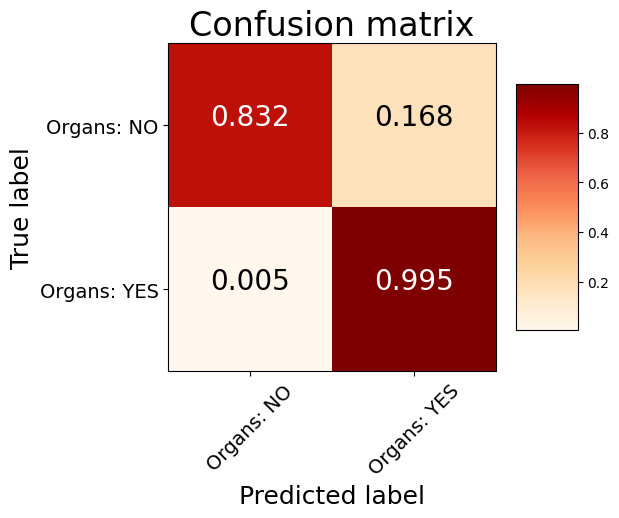

In [13]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= thr)
plot_confusion_matrix(cm,
                      ['Organs: NO', 'Organs: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
plt.savefig('images/confusion_classif.png', dpi=600)

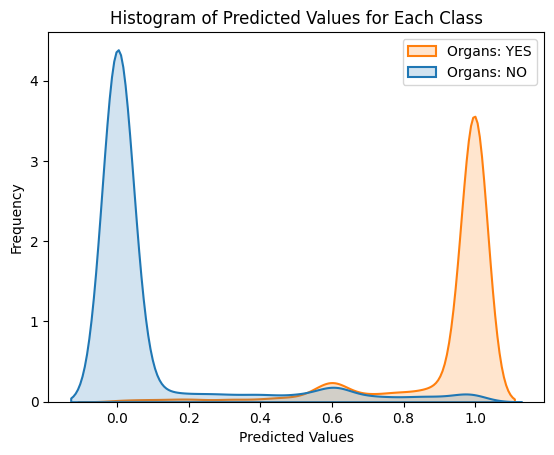

In [14]:
# Plot class distribution
plot_class_distribution(y_test, y_pred)
plt.savefig('images/distribution_classif.png', dpi=600)

Based on the evaluation results, the classification model demonstrates accurate prediction of the presence of organs of interest in the medical image. When aiming for a target recall of 99.5%, the false positive rate is 16.8%. In this specific use case, a very high recall score is paramount to ensure the classification model does not overlook potentially relevant slices for further segmentation. While a higher recall score results in an increased false positive rate, it is assumed that the segmentation model —the subsequent stage— can identify and generate zero masks for these cases.